![](../spam-940521_1920-1536x1086.jpg)

# Text Classification using Data Augmentation  📬

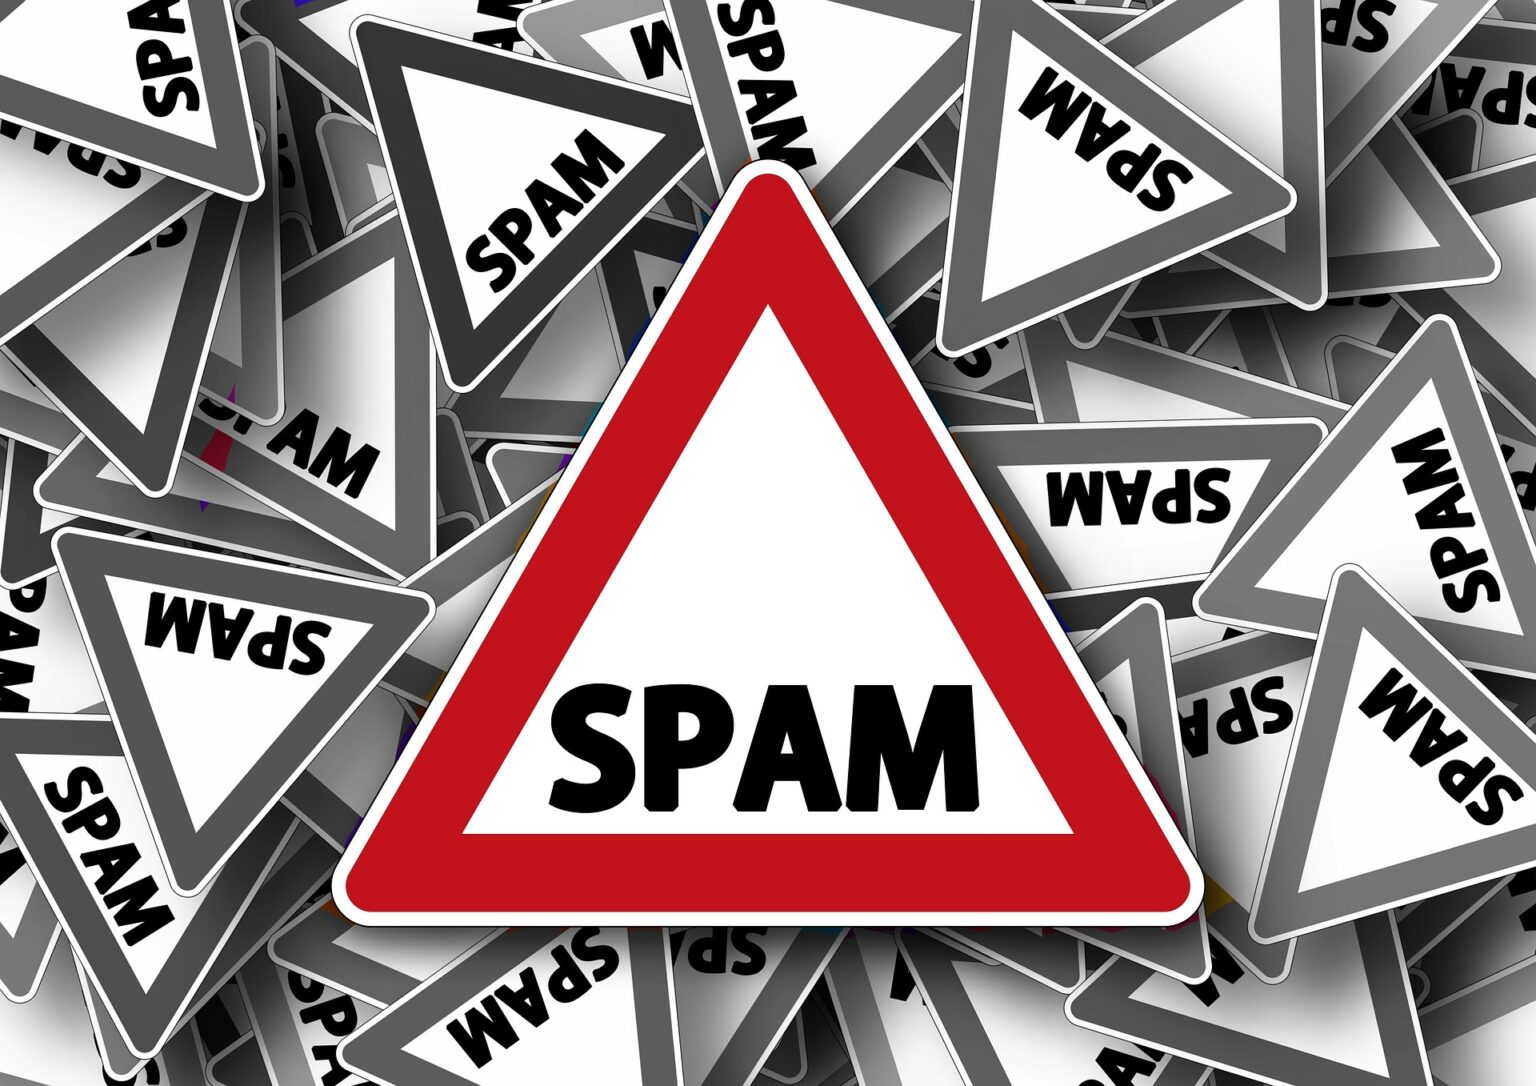

## Description:
This project is about a spam classifier is a Machine Learning model that classifies texts (email or SMS) into two categories: spam (0) or ham (1). The more data we have, the better performance we can achieve! 
## Objective:
In this project, we will see how to augment data in unbalanced text classes using word embeddings. By doing this, the aim is to improve our results of this exercice with text augmentation. To achieve that, we will apply preprocessing and Tf-Idf on a dataset of texts. Then we will use several Machine Learning classifiers to predict to which class belong a new email/SMS, based on the Tf-Idf.

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import spacy
from textblob import TextBlob 

In [ ]:
nlp = spacy.load('en_core_web_md')

In [60]:
df = pd.read_csv('../data/spam.csv', encoding = 'latin-1')

In [61]:
df.shape

(5572, 2)

In [62]:
df['Class'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Class, dtype: float64

The classes are highly unbalanced.

## Preprocessing:

### Map the target from categorical to numerical

In [63]:
df.Class = df.Class.apply(lambda x: 0 if x == 'spam' else 1)

### Process texts:
- Tokenize texts
- Lower case tokens and lemmatise tokens to reduce the number of features
- Keep only alphebtical tokens
- Remove punctuation
- Remove stop words
- Remove tokens that are have one character like "U" (to mean you) because they would disturb the tagger and thus the prediction.

In [64]:
def text_process_spacy(mess):
    tokens = [token.lemma_.lower() for token in nlp(mess) if token.is_alpha and not token.is_punct and not token.is_stop and len(token) > 1]
    return tokens

### We apply the process text on the Message column.

In [65]:
df['tokens'] = df.Message.apply(text_process_spacy)

### Split data into train and test datasets

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df.tokens, 
                                                    df.Class, 
                                                    test_size=0.2, 
                                                    stratify=df.Class, 
                                                    random_state=0)

### Function that transform texts into a features matrix

In [67]:
def tfidf_assembler(train_set, test_set):
    vec = TfidfVectorizer(analyzer=lambda x: x)
    tfidf_train = vec.fit_transform(train_set).toarray()
    tfidf_test = vec.transform(test_set).toarray()
    return tfidf_train, tfidf_test

In [68]:
tfidf_train, tfidf_test = tfidf_assembler(X_train, X_test)

#  Basic Modeling
- In order to evaluate properly our model, we should be using a metric that takes this unbalaceness into account. The **AUC score** is one of these metrics.
- The Area Under the Curve ROC **(AUC ROC)** indicates how well the probabilities from the positive classes are separated from the negative classes.
- We can also check the **f1-score** of the spam class (0).

In [69]:
classifiers = [LogisticRegression(), RandomForestClassifier(), 
               SVC(), GradientBoostingClassifier()]

for c in classifiers:
    c.fit(tfidf_train, y_train)
    y_pred = c.predict(tfidf_test)
    report = classification_report(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'scores for classifier {c}: \n {report} \n and auc score: {auc_score} \n\n')

scores for classifier LogisticRegression(): 
               precision    recall  f1-score   support

           0       0.97      0.77      0.86       149
           1       0.96      1.00      0.98       966

    accuracy                           0.97      1115
   macro avg       0.97      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115
 
 and auc score: 0.8809975405394139 


scores for classifier RandomForestClassifier(): 
               precision    recall  f1-score   support

           0       0.97      0.87      0.91       149
           1       0.98      1.00      0.99       966

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115
 
 and auc score: 0.9308155126655271 


scores for classifier SVC(): 
               precision    recall  f1-score   support

           0       0.99      0.89      0.93       149
           1       0.98      1.0

- Results are pretty good but what if we try to improve them with data augmentation? Let's apply this using word emebeddings.

In [70]:
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-100")

In [71]:
df

,Class,Message,tokens
0,1,"Go until jurong point, crazy.. Available only ...","[jurong, point, crazy, available, bugis, great..."
1,1,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, oni]"
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,1,U dun say so early hor... U c already then say...,"[dun, early, hor]"
4,1,"Nah I don't think he goes to usf, he lives aro...","[nah, think, go, usf, live]"
...,...,...,...
5567,0,This is the 2nd time we have tried 2 contact u...,"[time, try, contact, win, pound, prize, claim,..."
5568,1,Will ï¿½_ b going to esplanade fr home?,"[go, esplanade, fr, home]"
5569,1,"Pity, * was in mood for that. So...any other s...","[pity, mood, suggestion]"
5570,1,The guy did some bitching but I acted like i'd...,"[guy, bitching, act, like, interested, buy, we..."


# Data Augmentation
### Select only rows containing spams

In [95]:
spams = df.loc[df.Class == 0, "Message"]

### Correct spelling in order to make word emebedding work well

In [107]:
spams = spams.apply(lambda x: ''.join(TextBlob(x).correct()))

In [108]:
spams

2       Free entry in 2 a wily come to win of Up final...
5       FreeMsg Key there darling it's been 3 week's n...
8       WINNER!! Is a valued network customer you have...
9       Had your mobile 11 months or more? U R entitle...
11      SIX chances to win CASH! From 100 to 20,000 po...
                              ...                        
5537    Want explicit SEX in 30 seas? King 02073162414...
5540    ASKED 3MOBILE of 0870 CHATLINES INCLU of FREE ...
5547    Had your contract mobile 11 Months? Latest Mot...
5566    REMINDER FROM Of: To get 2.50 pounds free call...
5567    His is the and time we have tried 2 contact u....
Name: Message, Length: 747, dtype: object

### Get words POS tags tuples using spaCy

In [110]:
def pos_spacy(x):
    pos = [(token.lemma_.lower(), token.pos_) for token in nlp(x) if token.is_alpha and not token.is_punct and not token.is_stop and len(token) > 1]
    return pos

2    [(free, ADJ), (entry, NOUN), (wily, ADJ), (com...
5    [(freemsg, PROPN), (key, PROPN), (darle, VERB)...
Name: Message, dtype: object

In [111]:
pos_tags = spams.apply(pos_spacy)

In [112]:
pos_tags

2       [(free, ADJ), (entry, NOUN), (wily, ADJ), (com...
5       [(freemsg, PROPN), (key, PROPN), (darle, VERB)...
8       [(winner, PROPN), (value, VERB), (network, NOU...
9       [(mobile, ADJ), (month, NOUN), (entitle, VERB)...
11      [(chance, NOUN), (win, VERB), (cash, NOUN), (p...
                              ...                        
5537    [(want, VERB), (explicit, ADJ), (sex, NOUN), (...
5540    [(ask, VERB), (chatlines, PROPN), (inclu, PROP...
5547    [(contract, NOUN), (mobile, NOUN), (month, NOU...
5566    [(reminder, NOUN), (pound, NOUN), (free, ADJ),...
5567    [(time, NOUN), (try, VERB), (contact, NOUN), (...
Name: Message, Length: 747, dtype: object

In [ ]:
# example of how word embedding work
model.most_similar("house", topn = 1)[0][0]

In [114]:
test = pos_tags[2]

In [115]:
print(test)

[('free', 'ADJ'), ('entry', 'NOUN'), ('wily', 'ADJ'), ('come', 'VERB'), ('win', 'VERB'), ('final', 'ADJ'), ('receive', 'VERB'), ('entry', 'NOUN'), ('txt', 'NOUN'), ('apply', 'ADJ')]


### Select the most similar synonyms of tokens tagged as 'NOUN' by spaCy

In [116]:
def add_similar_spacy(text):
    new_spam = [model.most_similar(word, topn = 1)[0][0]
                if pos_tag == 'NOUN' and word in model.vocab
                else word for (word, pos_tag) in text]
    return new_spam

In [117]:
new_spams = pos_tags.apply(add_similar_spacy)

In [118]:
new_spams

2       [free, enter, wily, come, win, final, receive,...
5       [freemsg, key, darle, month, phrase, like, stu...
8       [winner, value, networks, customers, select, r...
9       [mobile, week, entitle, update, late, color, w...
11      [chances, win, money, pounds, obj, send, days,...
                              ...                        
5537    [want, explicit, sexual, ocean, king, office, ...
5540    [ask, chatlines, inclu, free, mins, india, cus...
5547    [contracts, wireless, week, late, motorola, fo...
5566    [reminders, pounds, free, loans, details, grea...
5567    [when, try, contacts, win, round, nobel, claim...
Name: Message, Length: 747, dtype: object

### Create a new dataframe using the new spams

In [119]:
new_labels = np.zeros(len(new_spams))

In [120]:
new_data = pd.DataFrame({'tokens': new_spams,
              'Class': new_labels})

In [121]:
len(spams)

747

In [122]:
len(new_spams)

747

In [124]:
new_data.Class = df.Class.astype('int')

### Concatenate the two dataframes

In [125]:
df_augmented = pd.concat([df.drop('Message', axis=1), new_data], axis=0)

### Split data into train and test datasets

In [126]:
X_train, X_test, y_train, y_test = train_test_split(df_augmented.tokens, 
                                                    df_augmented.Class, 
                                                    random_state=0, 
                                                    test_size=0.2, 
                                                    stratify=df_augmented.Class)

In [127]:
df_augmented.Class.value_counts(normalize=True)

1    0.76357
0    0.23643
Name: Class, dtype: float64

In [128]:
tfidf_train_a, tfidf_test_a = tfidf_assembler(X_train, X_test)

# Modeling using data augmentation

In [129]:
classifiers = [LogisticRegression(), RandomForestClassifier(), 
               SVC(), GradientBoostingClassifier()]

for c in classifiers:
    c.fit(tfidf_train_a, y_train)
    y_pred = c.predict(tfidf_test_a)
    report = classification_report(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'scores for classifier {c}: \n {report} \n and auc score: {auc_score} \n\n')

scores for classifier LogisticRegression(): 
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       299
           1       0.96      1.00      0.98       965

    accuracy                           0.96      1264
   macro avg       0.97      0.93      0.95      1264
weighted avg       0.97      0.96      0.96      1264
 
 and auc score: 0.9270573760548979 


scores for classifier RandomForestClassifier(): 
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       299
           1       0.98      0.99      0.99       965

    accuracy                           0.98      1264
   macro avg       0.98      0.96      0.97      1264
weighted avg       0.98      0.98      0.98      1264
 
 and auc score: 0.9595837593359557 


scores for classifier SVC(): 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       299
           1       0.98      1.0

**Results have clearly improved thanks to text augmentation applied!!!**
- Although correcting spelling helped to get the right pos and thus the right word emebedding, it didn't work in some cases like for: freemsg which has been tagged as proper name.